# Imports

In [241]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from time import time, sleep
from datetime import timedelta

# keep matplotlib interactive
%matplotlib notebook
# %matplotlib inline
# use ggplot style
plt.style.use('ggplot')

# Data Description
Description of users log.<br>
This is a daily log of users listening to music.

|              user_logs.csv                                              |
|-------------------------------------------------------------------------|
| msno       | user id  (letters, digits and special characters)          |
| date       | format %Y%m%d                                              |
| num_25     | # of songs played less than 25% of the song length         |
| num_50     | # of songs played between 25% to 50% of the song length    |
| num_75     | # of songs played between 50% to 75% of of the song length |
| num_985    | # of songs played between 75% to 98.5% of the song length  |
| num_100    | # of songs played over 98.5% of the song length            |
| num_unq    | # of unique songs played                                   |
| total_secs | total seconds played                                       |

In [ ]:
# user_log_dir = os.path.join(os.pardir, 'data', 'raw', 'user_logs.csv')
# Num_rows = int(20e6)

# # create file iterator
# reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
#         usecols = ['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

# # get a first chunk
# df_chunk = reader_iter.get_chunk(Num_rows)

# # compile bin edges to histogram
# Nbin = 1000
# Ncol = 5
# bin_edges = np.linspace( 0, Nbin, num=Nbin+1)
# hist_num_tot = np.array(np.zeros((Nbin,Ncol)))

# # histogram all columns separately, np.histogram return histo and bin edges, only need histo thus [0]
# # apply columnwise (column by column or along rows) thus 0 as 2nd argument of np.histogram
# hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, df_chunk.iloc[:,1:])

## User_log

### Number of songs played and song length played

In [13]:
Total_rows = sum(1 for line in open(user_log_dir))

In [116]:
# compile bin edges to histogram
Nbin = 1000
Ncol = 5
bin_edges = np.linspace( 0, Nbin, num=Nbin+1)
hist_num_tot = np.array(np.zeros((Nbin,Ncol)))

In [117]:
user_log_dir = os.path.join(os.pardir, 'data', 'raw', 'user_logs.csv')
Num_rows = int(20e6)

# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'num_25', 'num_50', 'num_75', 'num_985', 'num_100'])

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # histogram all log for num_x
    hist_num = np.apply_along_axis(lambda a: np.histogram(a, bins=bin_edges)[0], 0, df_chunk.iloc[:,1:])
    hist_num_tot = hist_num_tot + hist_num
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:08:26.738663 seconds ellapsed ---


Looking at the number of songs played, each percentile played have many zeros but they may not be happening at the same time. (25, 50, 75)% share a similar trend but different amplitude. However, 98.5% and 100% are rather unique. 

<IPython.core.display.Javascript object>


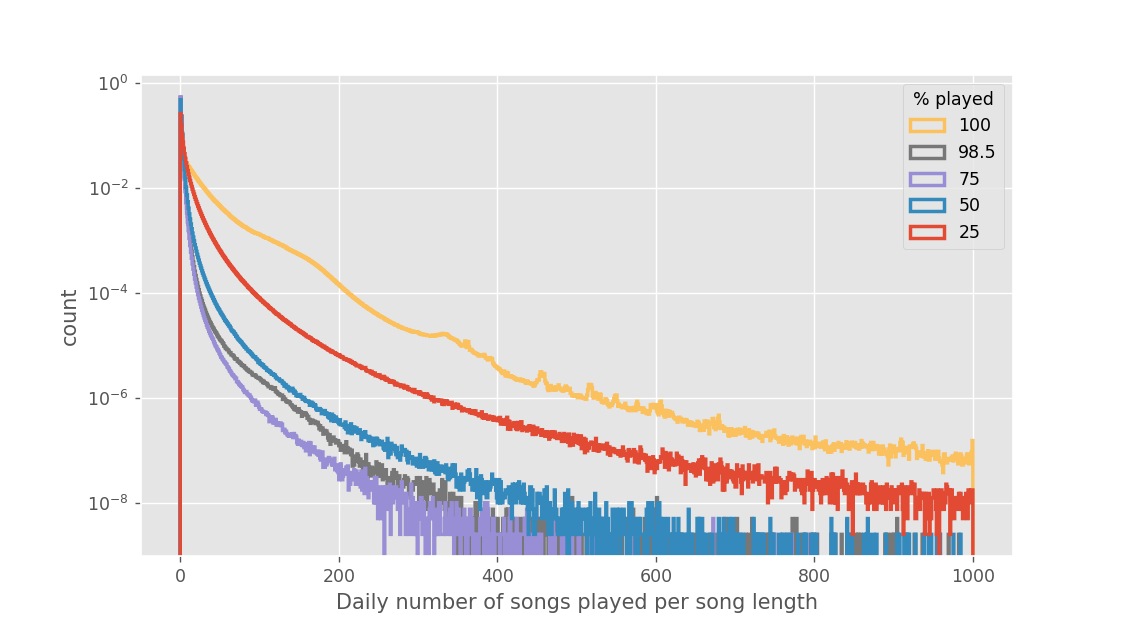

In [119]:
_ , ax = plt.subplots(figsize = (9, 5))

# extent bins to match the number of histogram
X_unit = np.tile(bin_edges[:-1], Ncol).reshape((-1,Ncol), order='F')

# prepare legend labels
legend_labels = ['25', '50', '75', '98.5', '100']

# plot histogram using weights
_ = ax.hist(X_unit, bins=bin_edges, weights=hist_num_tot, histtype='step',\
            alpha=1, linewidth = 2, label = legend_labels)

# change axis option
ax.set_yscale('log')
ax.set_ylabel('count')
ax.set_xlabel('Daily number of songs played per song length')

# add title to legend
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title = '% played')

### Number of unique song played

In [112]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'num_unq'])

# compile bin edges to histogram
hist_unq_tot = np.array(np.zeros((Nbin,)))

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # histogram all log for num_x
    hist_num, _ = np.histogram(df_chunk.iloc[:,1:], bins=bin_edges)
    hist_unq_tot +=  hist_num
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:07:00.078931 seconds ellapsed ---


There is at least one unique song for each entry otherwise there wouldn't be an entry.<br>
As the number of songs increases, its frequency decreases. Note there is a small peak at 100 songs.

<IPython.core.display.Javascript object>


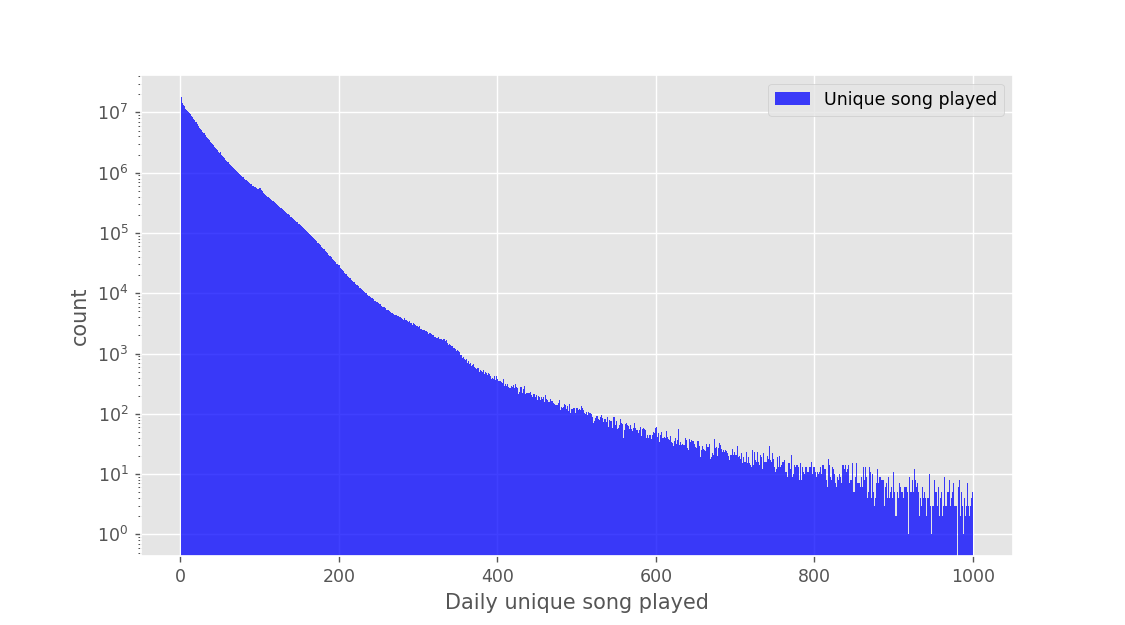

In [147]:
_ , axunq = plt.subplots(figsize = (9, 5))

# prepare legend labels
legend_labels = ['Unique song played']

# plot histogram using weights
_ = axunq.hist(bin_edges[:-1], bins=bin_edges, weights=hist_unq_tot, histtype='bar',\
            alpha=0.75, color = 'b',label = legend_labels)

# change axis option
axunq.set_yscale('log')
axunq.set_ylabel('count')
axunq.set_xlabel('Daily unique song played')

# add title to legend
axunq.legend()

### Total second played

In [142]:
# total number of bin
Nbin_tot = 24*60

# compute hourly bin
bin_edges_hourly = np.linspace( 0, Nbin_tot, num=25)

# Compute 1 min bin
bin_edges_bymin = np.linspace( 0, Nbin_tot, num=Nbin_tot+1)

In [144]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'total_secs'])

# compile bin edges to histogram
hist_hourly_tot = np.array(np.zeros((len(bin_edges_hourly)-1,)))
hist_bymin_tot = np.array(np.zeros((len(bin_edges_bymin)-1,)))


# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # convert totat secs to total minute
    total_min = df_chunk.iloc[:,1:]/60
    
    # histogram log hourly and by minute
    hist_hourly, _ = np.histogram(total_min, bins=bin_edges_hourly)
    hist_hourly_tot += hist_hourly
    
    hist_bymin, _ = np.histogram(total_min, bins=bin_edges_bymin)
    hist_bymin_tot += hist_bymin
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}%'.format(row_counter/Total_rows*100) ,end='', flush=True)

print("\n--- %s seconds ellapsed ---" % (timedelta(seconds = time() - start_time)))

      100.0%
--- 0:07:33.685531 seconds ellapsed ---


Total minutes played aggregated by hour shows a decline in frequency as time increases.<br>
Looking at the smae data by minute, we can see peaks forming every 15 minutes roughly. Below 15 minutes, the most frequent time is 3-4 minutes.

<IPython.core.display.Javascript object>


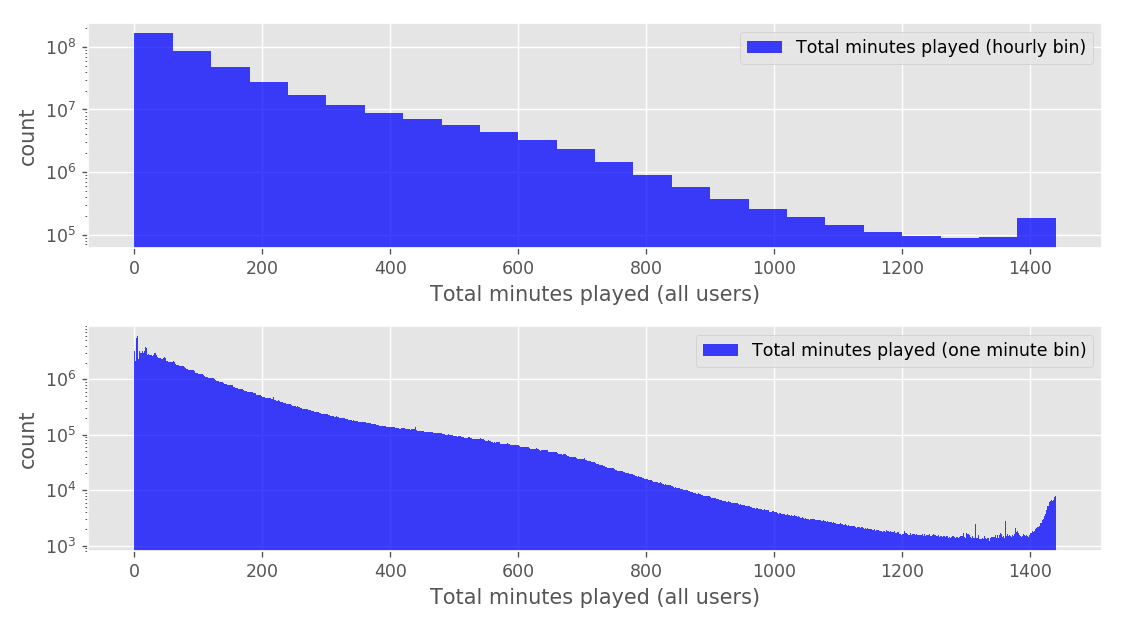

In [155]:
_ , axtotsec = plt.subplots(2, 1, figsize = (9, 5))

# prepare legend labels, bin edge
legend_labels = ['Total minutes played (hourly bin)', 'Total minutes played (one minute bin)']
bin_edges_list = [bin_edges_hourly, bin_edges_bymin]
histo_list = [hist_hourly_tot, hist_bymin_tot]

# plot histogram using weights
for ax, bedge, h, l in zip(axtotsec,bin_edges_list,histo_list,legend_labels):
    _ = ax.hist(bedge[:-1], bins=bedge, weights=h, histtype='bar',\
                alpha=0.75, color = 'b', linewidth = 2, label = l)

    # change axis option
    ax.set_yscale('log')
    ax.set_ylabel('count')
    ax.set_xlabel('Total minutes played (all users)')

    # add title to legend
    ax.legend()
    plt.tight_layout()

In order to gauge customer activity over time, we will look at the total seconds played as a function of time.

In [243]:
# create file iterator
reader_iter = pd.read_csv(user_log_dir, index_col = 'date', parse_dates=['date'], chunksize=Num_rows,\
        usecols = ['msno', 'date', 'total_secs'])

# empty series to aggregate total seconds
s_tot_secs = pd.Series()

# get start time of timer for processing time
start_time = time()
row_counter = 0

for df_chunk in reader_iter:
    
    # convert totat secs to total minute
    total_second = df_chunk.iloc[:,1:]
    
    # group by day and aggregate using sum()
    s_sec = total_second.groupby(pd.Grouper(level='date', freq='D'))['total_secs'].sum()
    
    # add last time serie to global time serie
    s_tot_secs = s_tot_secs.add(s_sec, fill_value = 0)
    
    # get track of progress
    row_counter += df_chunk.shape[0]
    print('\r {:10.1f}% done \t--- {} seconds ellapsed ---'.format(row_counter/Total_rows*100,\
                                timedelta(seconds = time() - start_time)) ,end='', flush=True)

      100.0% done 	--- 0:09:37.487402 seconds ellapsed ---

<IPython.core.display.Javascript object>


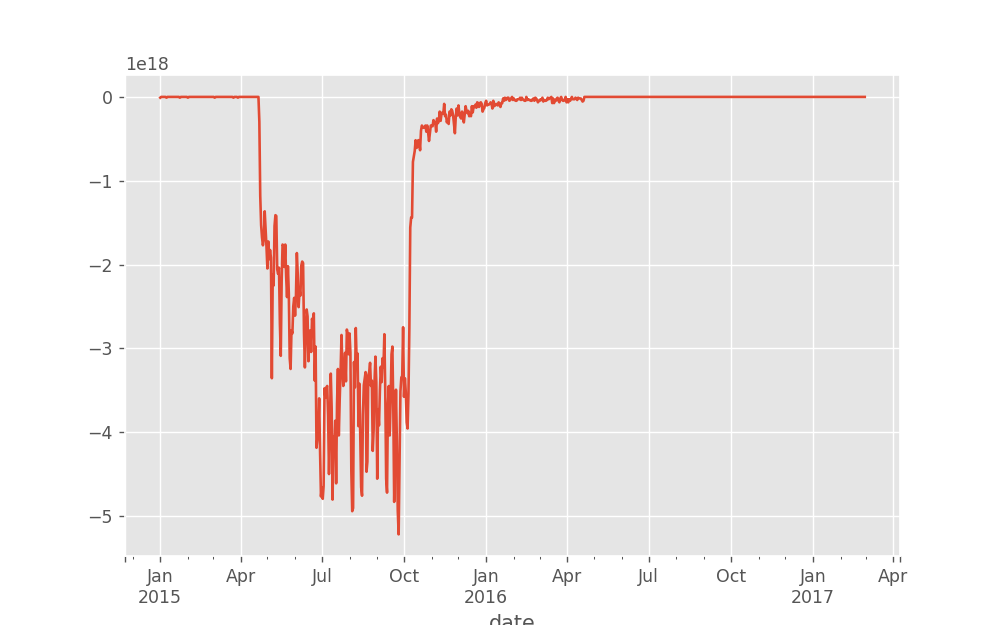

In [244]:
_ , axact = plt.subplots(figsize = (8, 5))
s_tot_secs.plot(ax = axact)

In [232]:
hist_hourly_tot.sum()

391902057.0

In [233]:
Total_rows

392106544

In [229]:
s_tot_secs.describe()

count    7.900000e+02
mean    -7.171319e+17
std      1.355635e+18
min     -5.220429e+18
25%     -3.205122e+17
50%      3.575588e+09
75%      4.385625e+09
max      4.719736e+14
dtype: float64

In [237]:
s_tot_secs.plot(ax = axact)
plt.tight_layout()

### Watermark

In [ ]:
# once it is installed, you'll just need this in future notebooks:
%load_ext watermark
%watermark -a "Cedric Herman" -d -t -v -p numpy,pandas,matplotlib,seaborn,tqdm,ipywidgets

In [ ]:
# %watermark -iv